# Multivariate time series using FB Prophet

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mp
from datetime import datetime
import plotly.express as px

mp.rcParams['figure.figsize'] = (10,8)
mp.rcParams['axes.grid'] = True

In [65]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df['timeStamp'] = pd.to_datetime(df['timeStamp'])


ny_df = df.set_index('timeStamp') # SETTING THE INDEX

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [67]:
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49205 entries, 2012-01-01 00:00:00 to 2017-08-12 06:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  49124 non-null  float64
 1   precip  48975 non-null  float64
 2   temp    49019 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [68]:
df.shape

(49205, 4)

## Resampling it to the Day Level

In [69]:
ny_df_daily = ny_df.resample('D').mean()

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

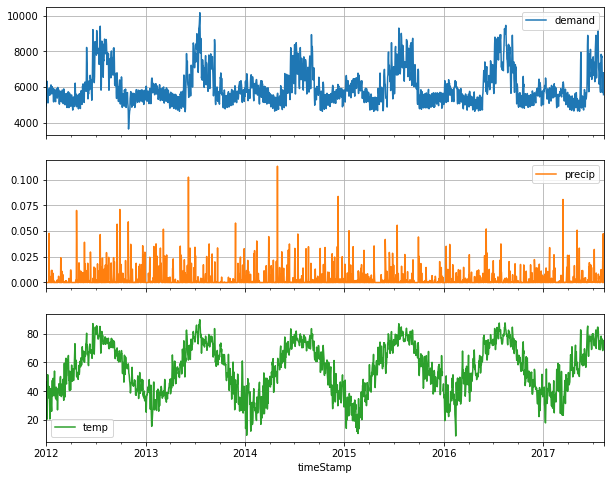

In [70]:
ny_df_daily.plot(subplots=True)

In [71]:
ny_df_daily.head(2)

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667


## NOTE : the Prophet requires the timestamp column to be named as ds!!

In [72]:
from fbprophet import Prophet

ny_df_final = ny_df_daily.reset_index()[['timeStamp', 'demand', 'temp']].rename({'timeStamp' : 'ds', 'demand' : 'y', 'temp' : 'temp'}, axis='columns')
ny_df_final

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
...,...,...,...
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917


In [73]:
ny_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2051 non-null   datetime64[ns]
 1   y       2049 non-null   float64       
 2   temp    2050 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.2 KB


### There are missing values in the TARGET column so prophet will take care of those missing values in target column... BUT for the other feature facebook does not handle the missing values. so manually impute those

In [74]:
ny_df_final.query('temp != temp') # BASICALLY NaN IS NOT EQUAL TO ANOTHER NaN BCOZ ITS AN OBJECT NOT A VALUE

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [75]:
ny_df_final[ny_df_final['temp'].isnull()]

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [76]:
ny_df_final['temp'] = ny_df_final['temp'].fillna(method='ffill')


## Extrating the month feature from the ds column and storing it into a new feature

In [79]:
ny_df_final['month'] = ny_df_final['ds'].dt.month

In [80]:
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [81]:
import plotly.express as px
fig = px.line(ny_df_final, x='ds', y='y',hover_data=['temp', 'month'], title='NYC Energy Demand')

fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                 buttons=list([
                     dict(count=1, label="1y", step="year", stepmode="backward"),
                     dict(count=2, label="2y", step="year", stepmode="backward"),
                     dict(count=3, label="3y", step="year", stepmode="backward"),
                     dict(step="all")
                 ])))
fig.show()

### Calculating the avg. temperature every month

In [82]:
ny_df_final['temp']

0       46.510000
1       40.496667
2       26.672500
3       20.585000
4       33.577500
          ...    
2046    71.039167
2047    73.852500
2048    75.217500
2049    72.767917
2050    69.771429
Name: temp, Length: 2051, dtype: float64

In [83]:
ny_df_final[['month', 'temp']].groupby('month').agg({'temp':{'max', 'min', 'mean'}})

temp                      
             min       mean        max
month                                 
1       9.507917  33.432140  55.420455
2       9.015000  34.517758  59.360000
3      20.291667  41.419884  67.878333
4      33.045833  52.600204  72.992083
5      48.090833  62.543994  82.576250
6      52.405833  71.334418  86.916667
7      66.417083  77.595627  89.606667
8      68.042083  75.525947  87.426250
9      57.274583  69.550306  84.448750
10     42.106250  58.642895  74.277500
11     27.172500  47.225638  67.606250
12     22.429583  41.520068  64.735000

In [85]:
ny_df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [86]:
ny_df_final.query('temp > 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [88]:
ny_df_final[ny_df_final['temp']>80][['y', 'temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [89]:
ny_df_final.query('temp < 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [90]:
def summer_temp(temp):
    if temp>80:
        return 1
    else:
        return 0

### Creating a new variable and then assigning the temp if its above 80

In [92]:
ny_df_final['summer_temp'] = ny_df_final['temp'].apply(summer_temp)

In [93]:
ny_df_final['monthly_bins'] = pd.cut(ny_df_final['month'], bins=3, labels=False)

In [105]:
ny_df_final


,ds,y,temp,month,summer_temp,monthly_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0
...,...,...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1


In [106]:
train = ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'] <= '2017-04-30')]

In [107]:
train.shape, test.shape

((1947, 6), (1947, 6))

In [108]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [109]:
m.add_regressor('summer_temp', standardize=False) # here the mode will be additive
m.add_regressor('monthly_bins', standardize=False, mode='multiplicative') # when you want 2 variables to have interaction

In [110]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
m.params

{'k': array([[0.13958491]]),
 'm': array([[0.58924189]]),
 'delta': array([[ 2.65313072e-07, -1.74318726e-05, -1.73164542e-01,
         -1.05301456e-07,  5.59386390e-08,  1.25027341e-02,
          7.72354868e-03,  5.51889805e-03,  9.72178119e-04,
          3.79771004e-08, -3.24903007e-08, -4.72795549e-02,
         -2.42926627e-08,  1.32688411e-08,  1.35631134e-01,
          2.58515841e-05, -4.56850344e-08, -8.74421947e-02,
         -3.87043389e-02, -4.80666361e-08, -4.04173531e-08,
          2.05922438e-07,  3.15439941e-02,  2.23325637e-02,
          1.95718276e-08]]),
 'sigma_obs': array([[0.03885294]]),
 'beta': array([[-0.03553589, -0.05912678,  0.04942024,  0.04013984, -0.00951791,
         -0.0017678 , -0.00780795, -0.00252233,  0.00341816, -0.00586087,
          0.00139401,  0.00306055, -0.00525902, -0.00380461,  0.00336162,
         -0.00276727,  0.00071113,  0.00143633, -0.00131768, -0.00031711,
         -0.02719373,  0.02415133,  0.02027329,  0.00152746, -0.00497216,
         

### Just making future 104 days 

In [112]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [115]:
future['summer_temp'] = ny_df_final['summer_temp']
future['monthly_bins'] = ny_df_final['monthly_bins']

In [116]:
future

,ds,summer_temp,monthly_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0
...,...,...,...
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1


In [117]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7376.406641,6598.885236,8163.866797
2047,2017-08-09,7387.201289,6639.321491,8127.823678
2048,2017-08-10,7357.497487,6559.841412,8199.717139
2049,2017-08-11,7307.263418,6546.417027,8068.073397
2050,2017-08-12,6726.363455,5925.549481,7555.637516


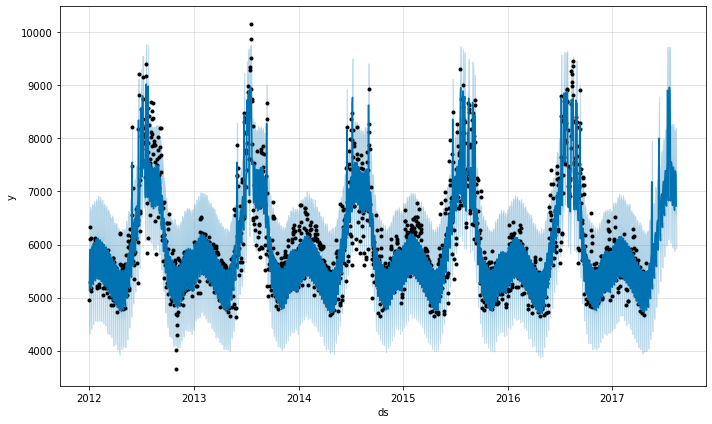

In [118]:
fig1 = m.plot(forecast)

d:\anacondafiles\envs\deeplearning\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



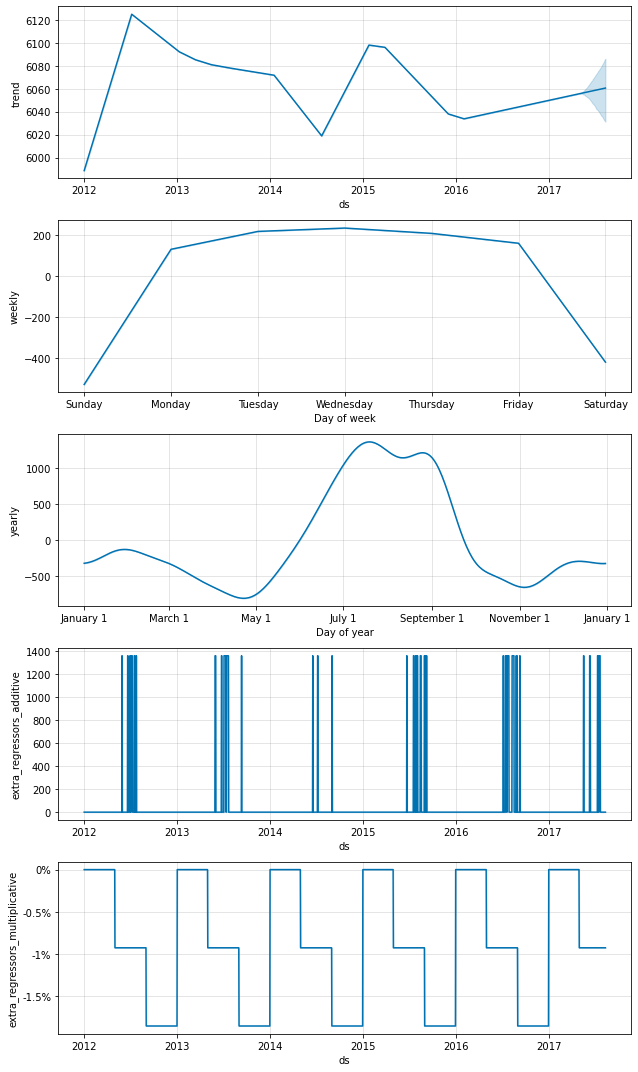

In [119]:
fig2 = m.plot_components(forecast)

In [120]:
from fbprophet.diagnostics import cross_validation, performance_metrics
cv_results = cross_validation(model = m, initial='731 days', horizon='365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,203706.204840,451.338238,352.608713,0.062538,0.051537,0.895604
1,37 days 00:00:00,209754.996350,457.990171,359.590764,0.063716,0.052701,0.884615
2,37 days 12:00:00,211007.054695,459.355042,361.929745,0.064109,0.053764,0.884615
3,38 days 00:00:00,215090.481158,463.778483,365.952816,0.064517,0.054092,0.879121
4,38 days 12:00:00,217294.074439,466.148125,369.826176,0.065133,0.055147,0.879121
...,...,...,...,...,...,...,...
653,363 days 00:00:00,152220.128295,390.153980,329.148285,0.060273,0.060875,0.978022
654,363 days 12:00:00,152733.840337,390.811771,329.171659,0.060278,0.060875,0.978022
655,364 days 00:00:00,155888.652826,394.827371,331.903789,0.060981,0.061061,0.972527
656,364 days 12:00:00,155401.364264,394.209797,330.627365,0.060767,0.061025,0.972527


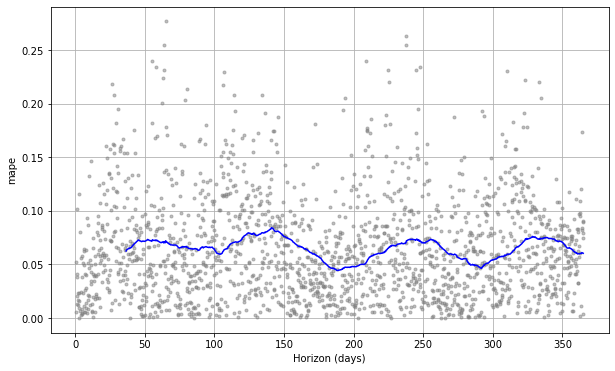

In [121]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')